# Call Rate Modeling

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

import copy

### Data Pre-Processing

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


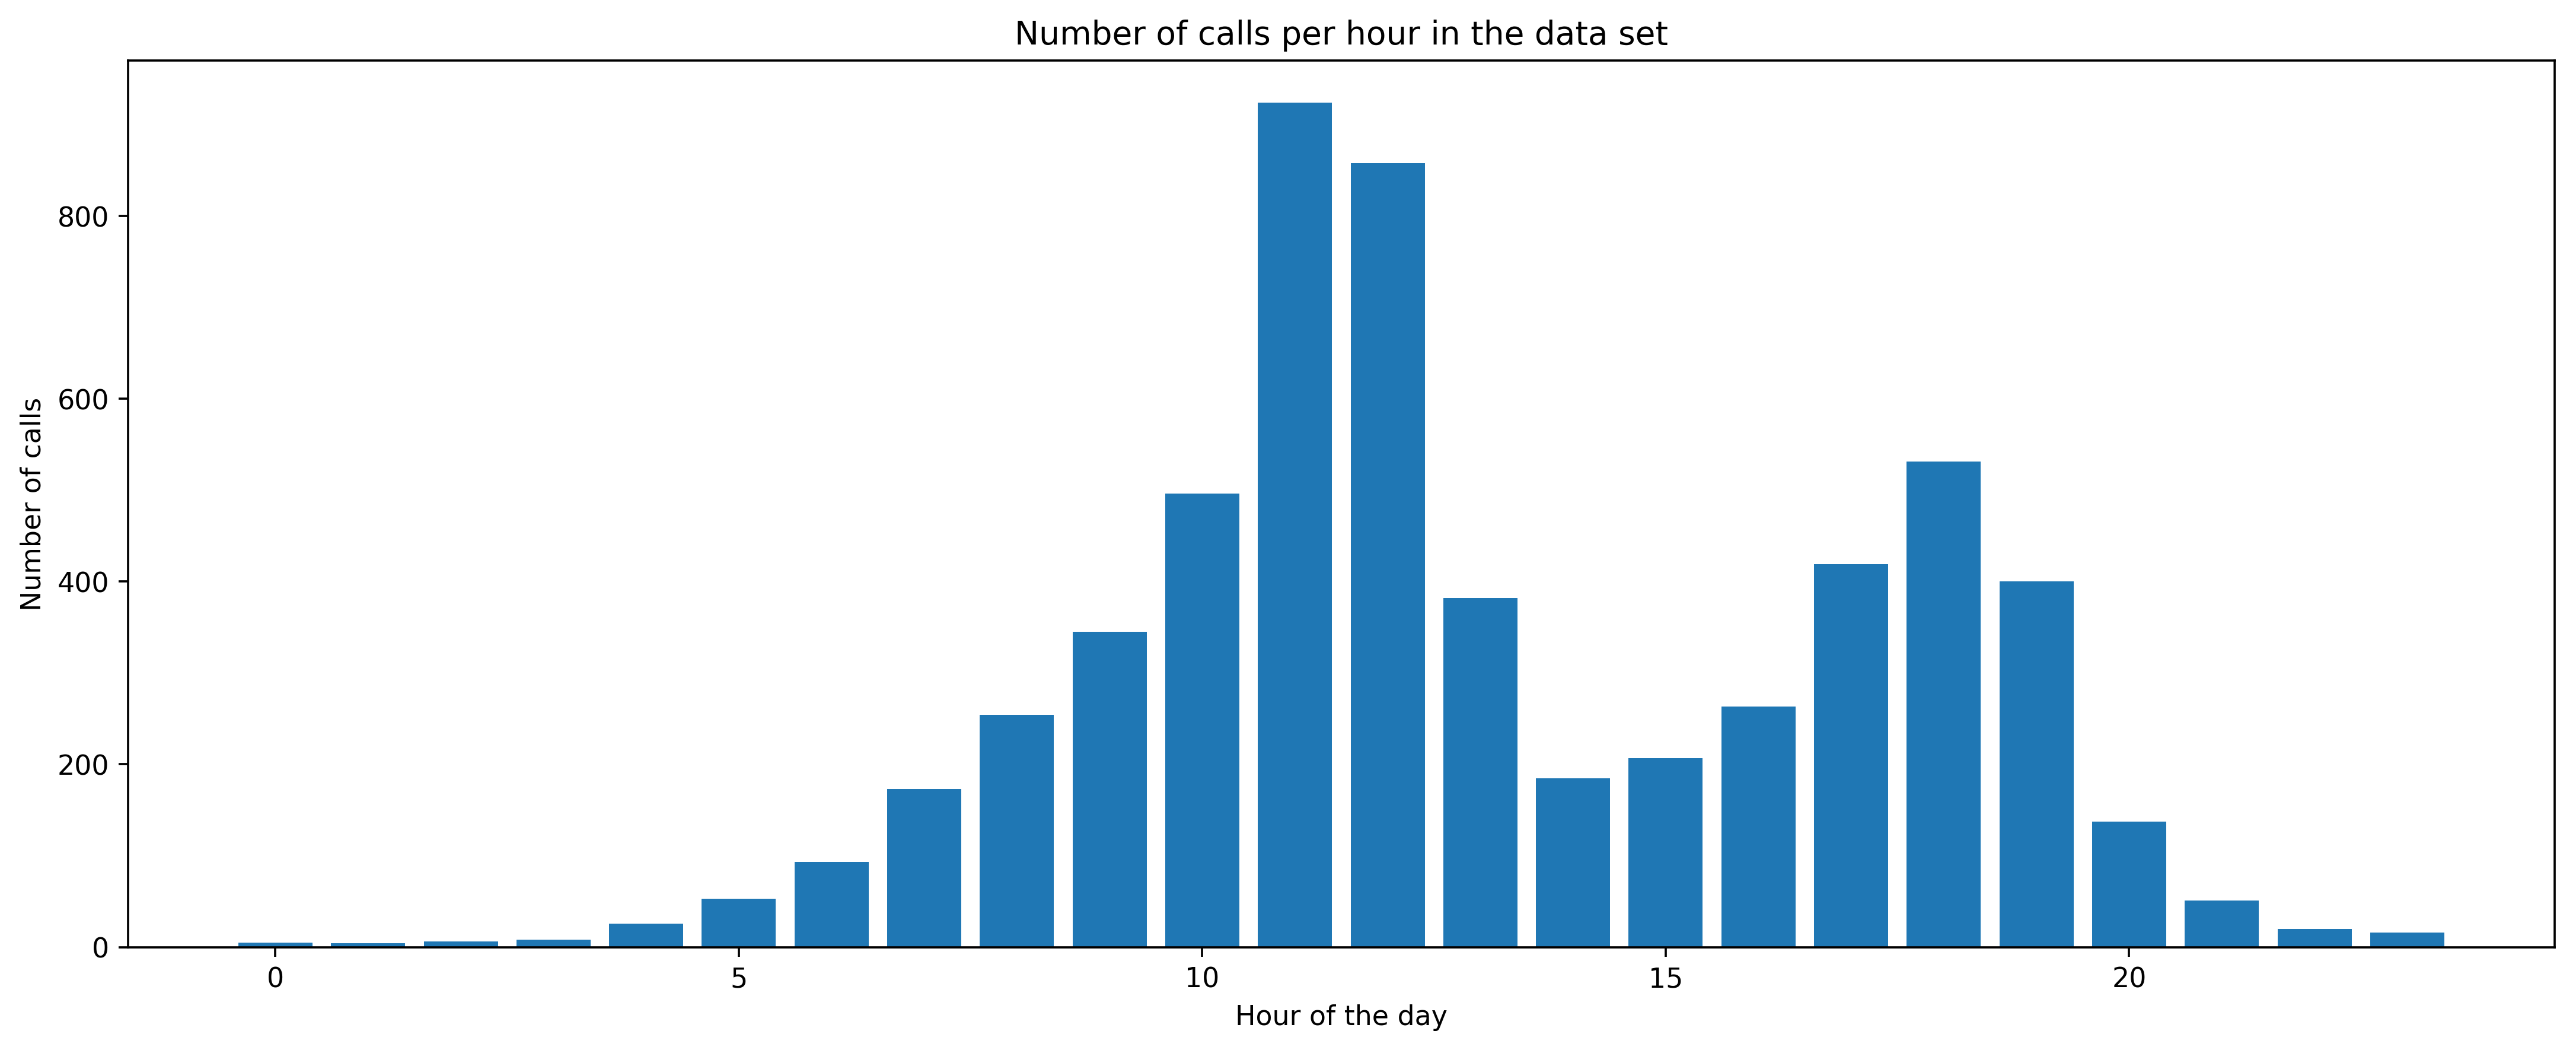

In [3]:
# Plot the number of calls per hour using a bar chart
plt.figure(figsize=(16, 6), dpi=330)
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.xlabel('Hour of the day')
plt.ylabel('Number of calls')
plt.title('Number of calls per hour in the data set')
plt.show()

### Distribution of Times Between Calls

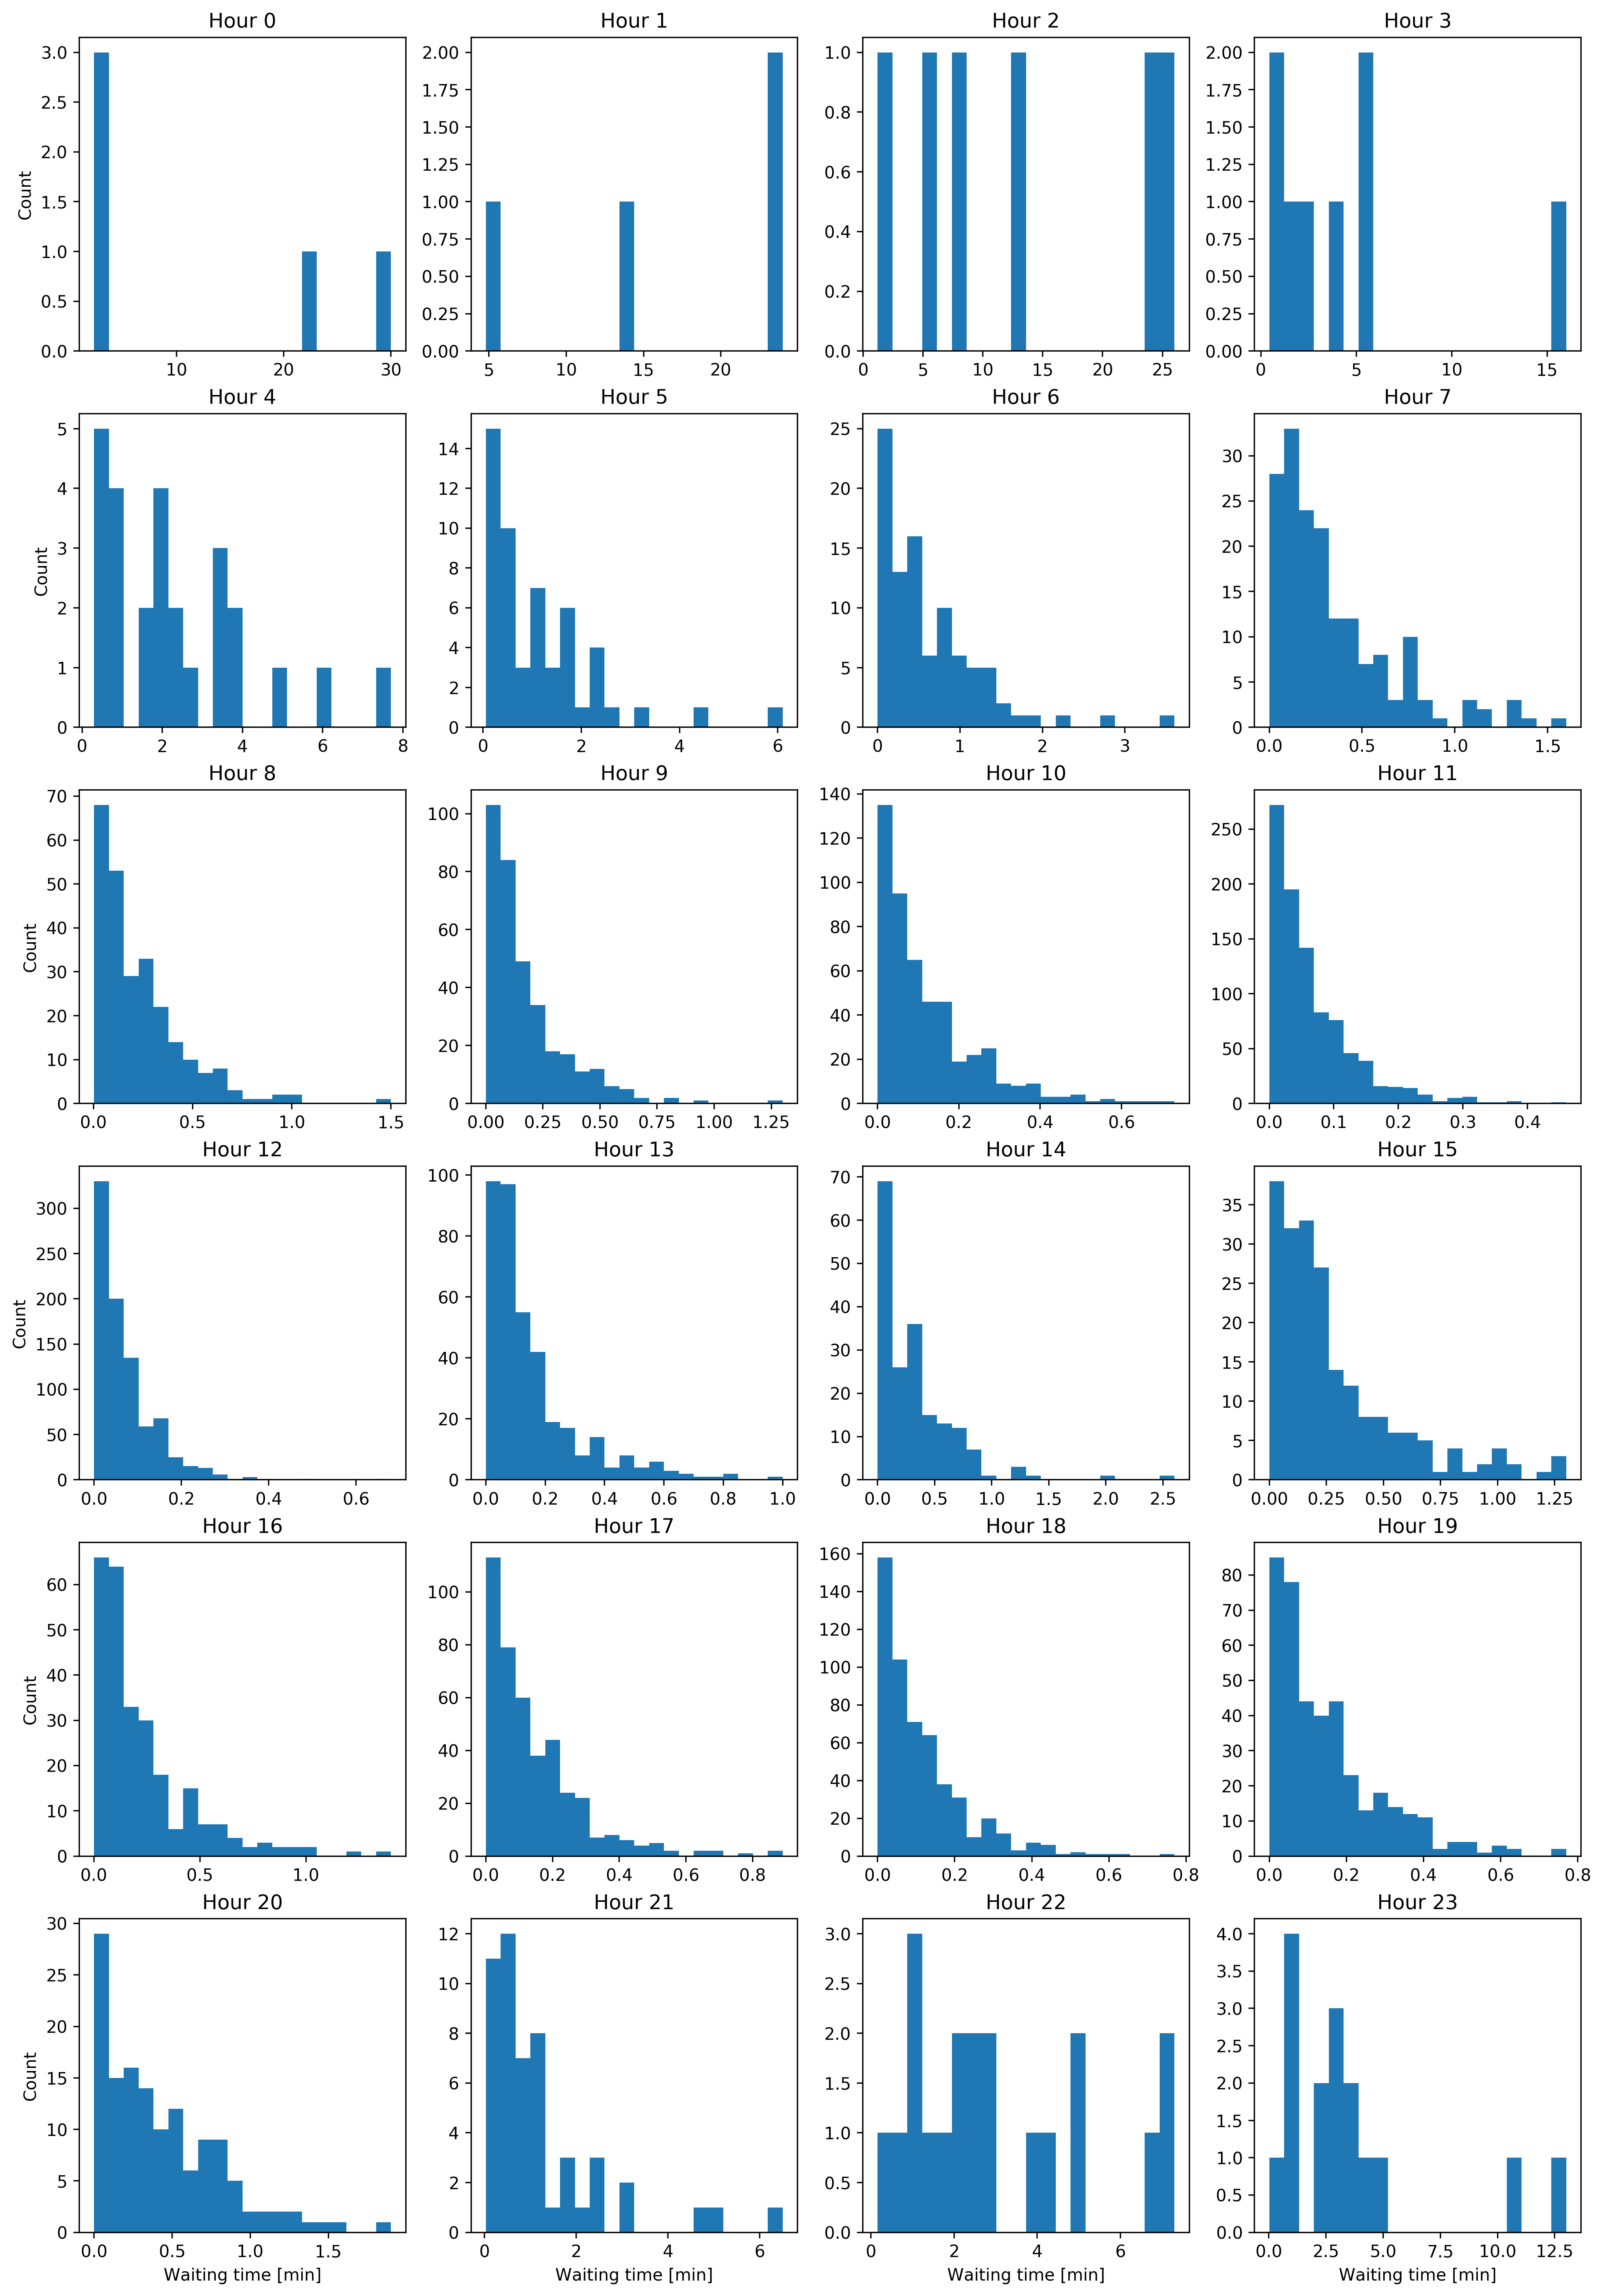

In [4]:
# Plot histogram of waiting times for all 24 hours
hours = range(24)
plt.figure(figsize=(16, 24), dpi=330)
    
for hour in hours:
    waiting_times_hour = waiting_times_per_hour[hour]
    plt.subplot(6, 4, hour + 1)
    plt.hist(waiting_times_hour, bins=20)
    plt.title('Hour {}'.format(hour))
    
    if hour >= 20:
        plt.xlabel('Waiting time [min]')
    if hour % 4 == 0:
        plt.ylabel('Count')
    
plt.show()

### Choosing a Likelihood Function

Looking at the distributions, most of the time it looks like an exponential likelihood. In some places, it seems like it'd be nice to fit a gamma likelihood (hours 1, 3, 22, 23) with unknown $\alpha$ and $\beta$ but this might not be a good idea because there is very little data points at these hours (less than 20), so a maximum likelihood estimator might be too opinionated and overfit the data. Therefore, we will go with an exponential likelihood.

The MLE of $\lambda$ (the rate) in an exponential function is the mean of the data.

### Choosing a Prior
A nice thing about the exponential likelihood is that we can use a gamma conjugate prior with it. Gamma prior would be an amazing thing here to "balance out" the hours with rare calls when the likelihood is an exponential which moves the tip of the distribution to zero. Since we're using conjugate prior, we don't even need to explicitly write out the likelihood distribution because there are update rules for the $\alpha$ and $\beta$ parameters.

In [5]:
class CallRatePDF:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.prior_alpha = alpha
        self.prior_beta = beta
        
    # return pdf at range of lambdas
    def pdf(self, lambdas):
        distrib = sts.gamma(self.alpha, scale=1 / self.beta)
        return distrib.pdf(lambdas)
    
    # return prior pdf at range of lambdas
    def prior_pdf(self, lambdas):
        distrib = sts.gamma(self.prior_alpha, scale=1 / self.prior_beta)
        return distrib.pdf(lambdas)
    
    # get posterior estimates of parameters
    def add_data(self, waiting_times):
        data = np.array(waiting_times)
        # storing the prior parameters
        self.prior_alpha = self.alpha 
        self.prior_beta = self.beta
        
        self.alpha += data.shape[0]
        self.beta += np.sum(data)

### Initializing Priors for Each Hour
I have a belief that the call rate would peak is hour 9 (9 am to 10 am, when people are at work), and the distribution of call time will decay quickly on the left side of the distribution (hour 0 to hour 9) and decay slowly on the right side of the distribution (hour 9 to hour 23). I will use a scaled and stretched log-normal distribution centered near 9 to emulate this behavior. 

In [6]:
# I just hand-picked parameters so it looked right
init_distrib = sts.lognorm(s=0.9, loc=-2, scale=25)
unscaled_call_rate = init_distrib.pdf(range(24))

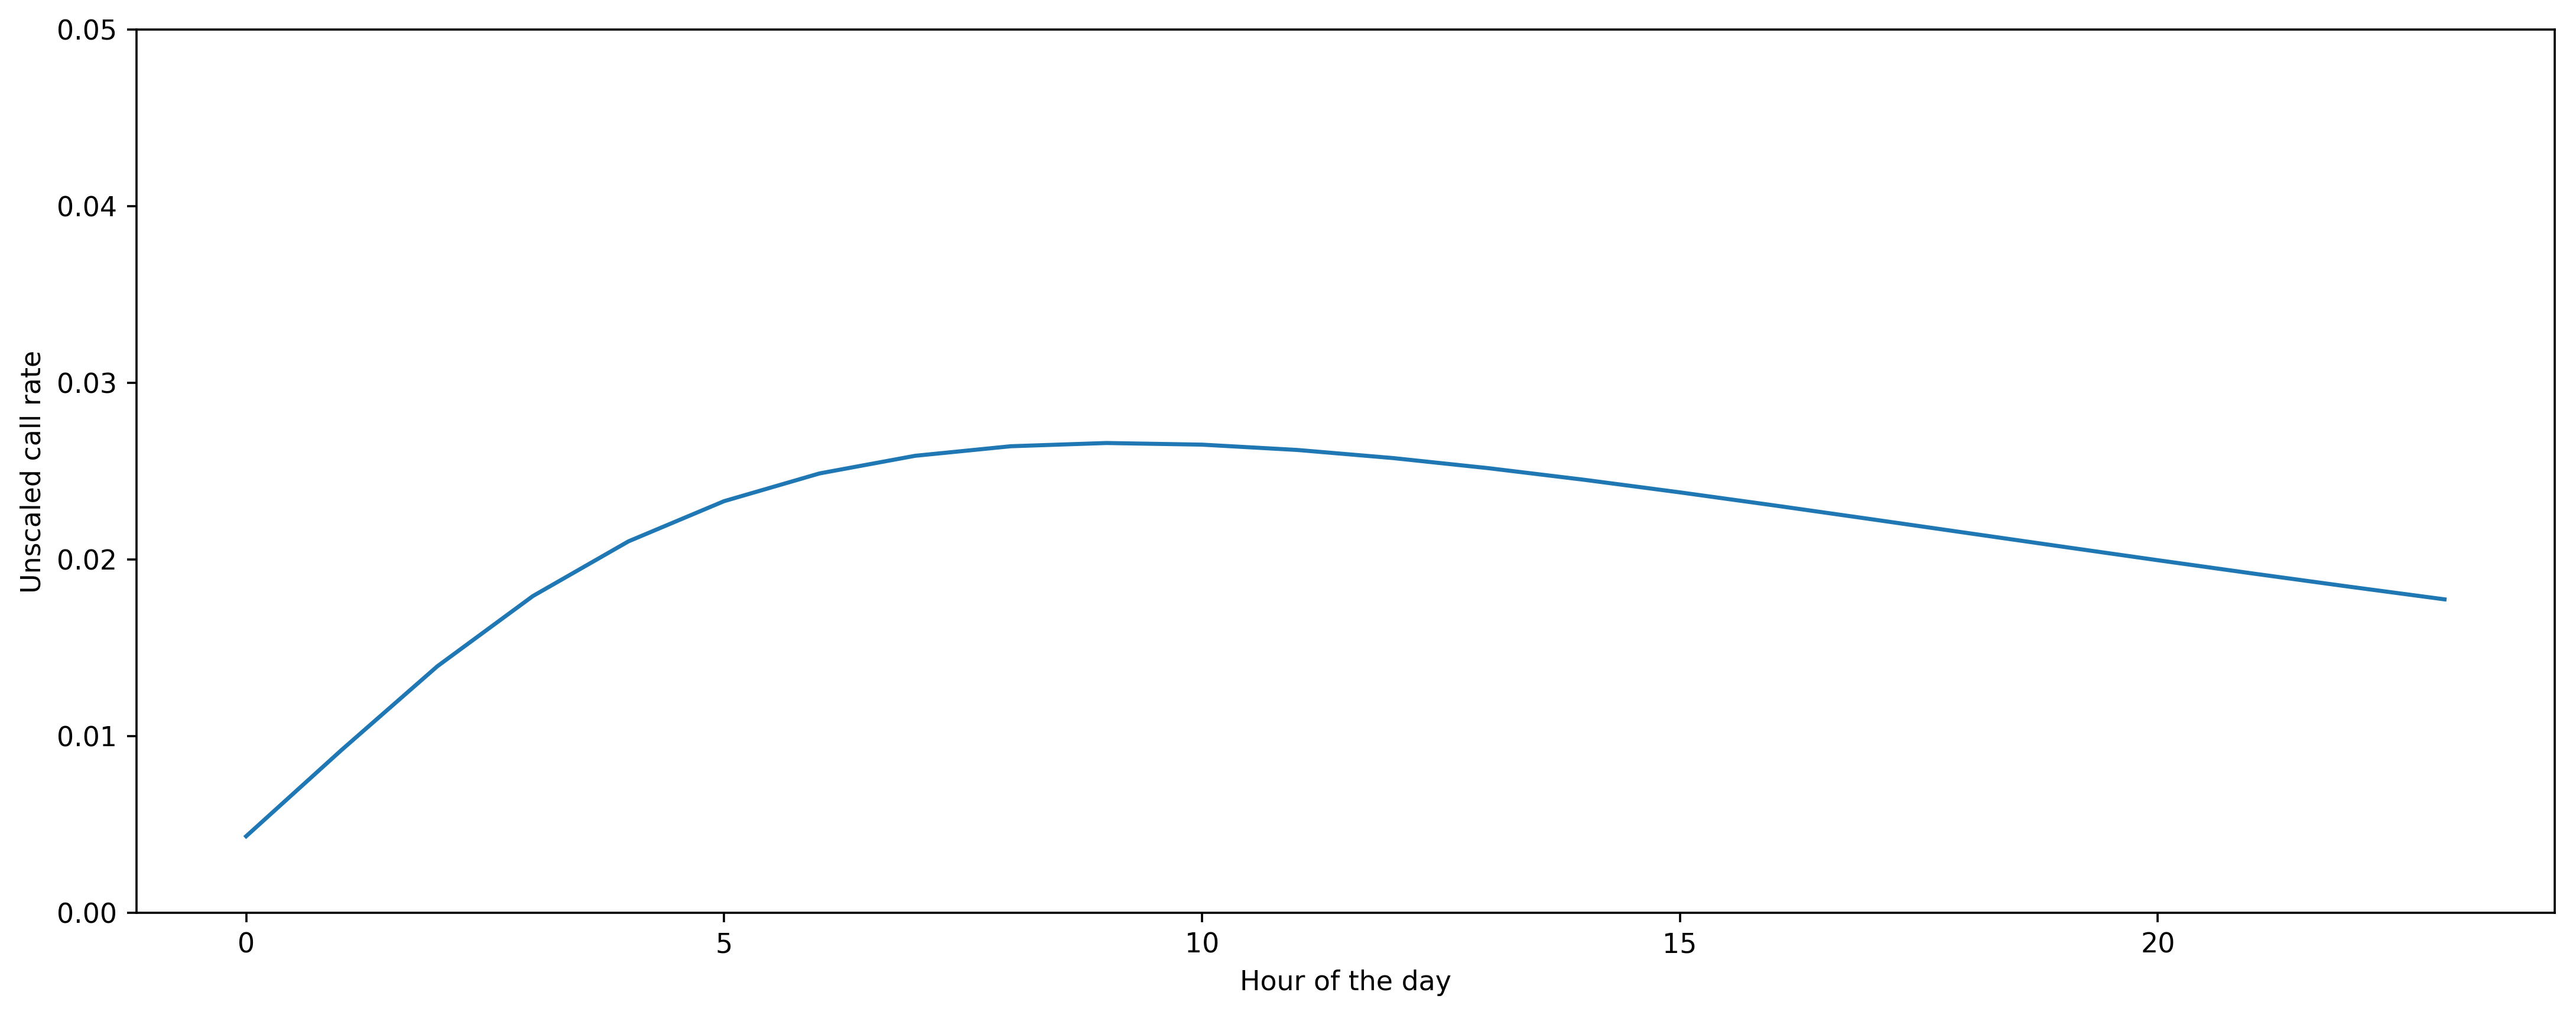

In [7]:
plt.figure(figsize=(16, 6), dpi=330)
plt.plot(range(24), unscaled_call_rate)
plt.ylim((0, 0.05))
plt.xlabel('Hour of the day')
plt.ylabel('Unscaled call rate')
plt.show()

Looks quite good. Now, I think there will be around 3 calls per minute at hour 9, so I will scale this distribution, so that the peak was at 3.

In [8]:
call_rate = unscaled_call_rate / init_distrib.pdf(9) * 3

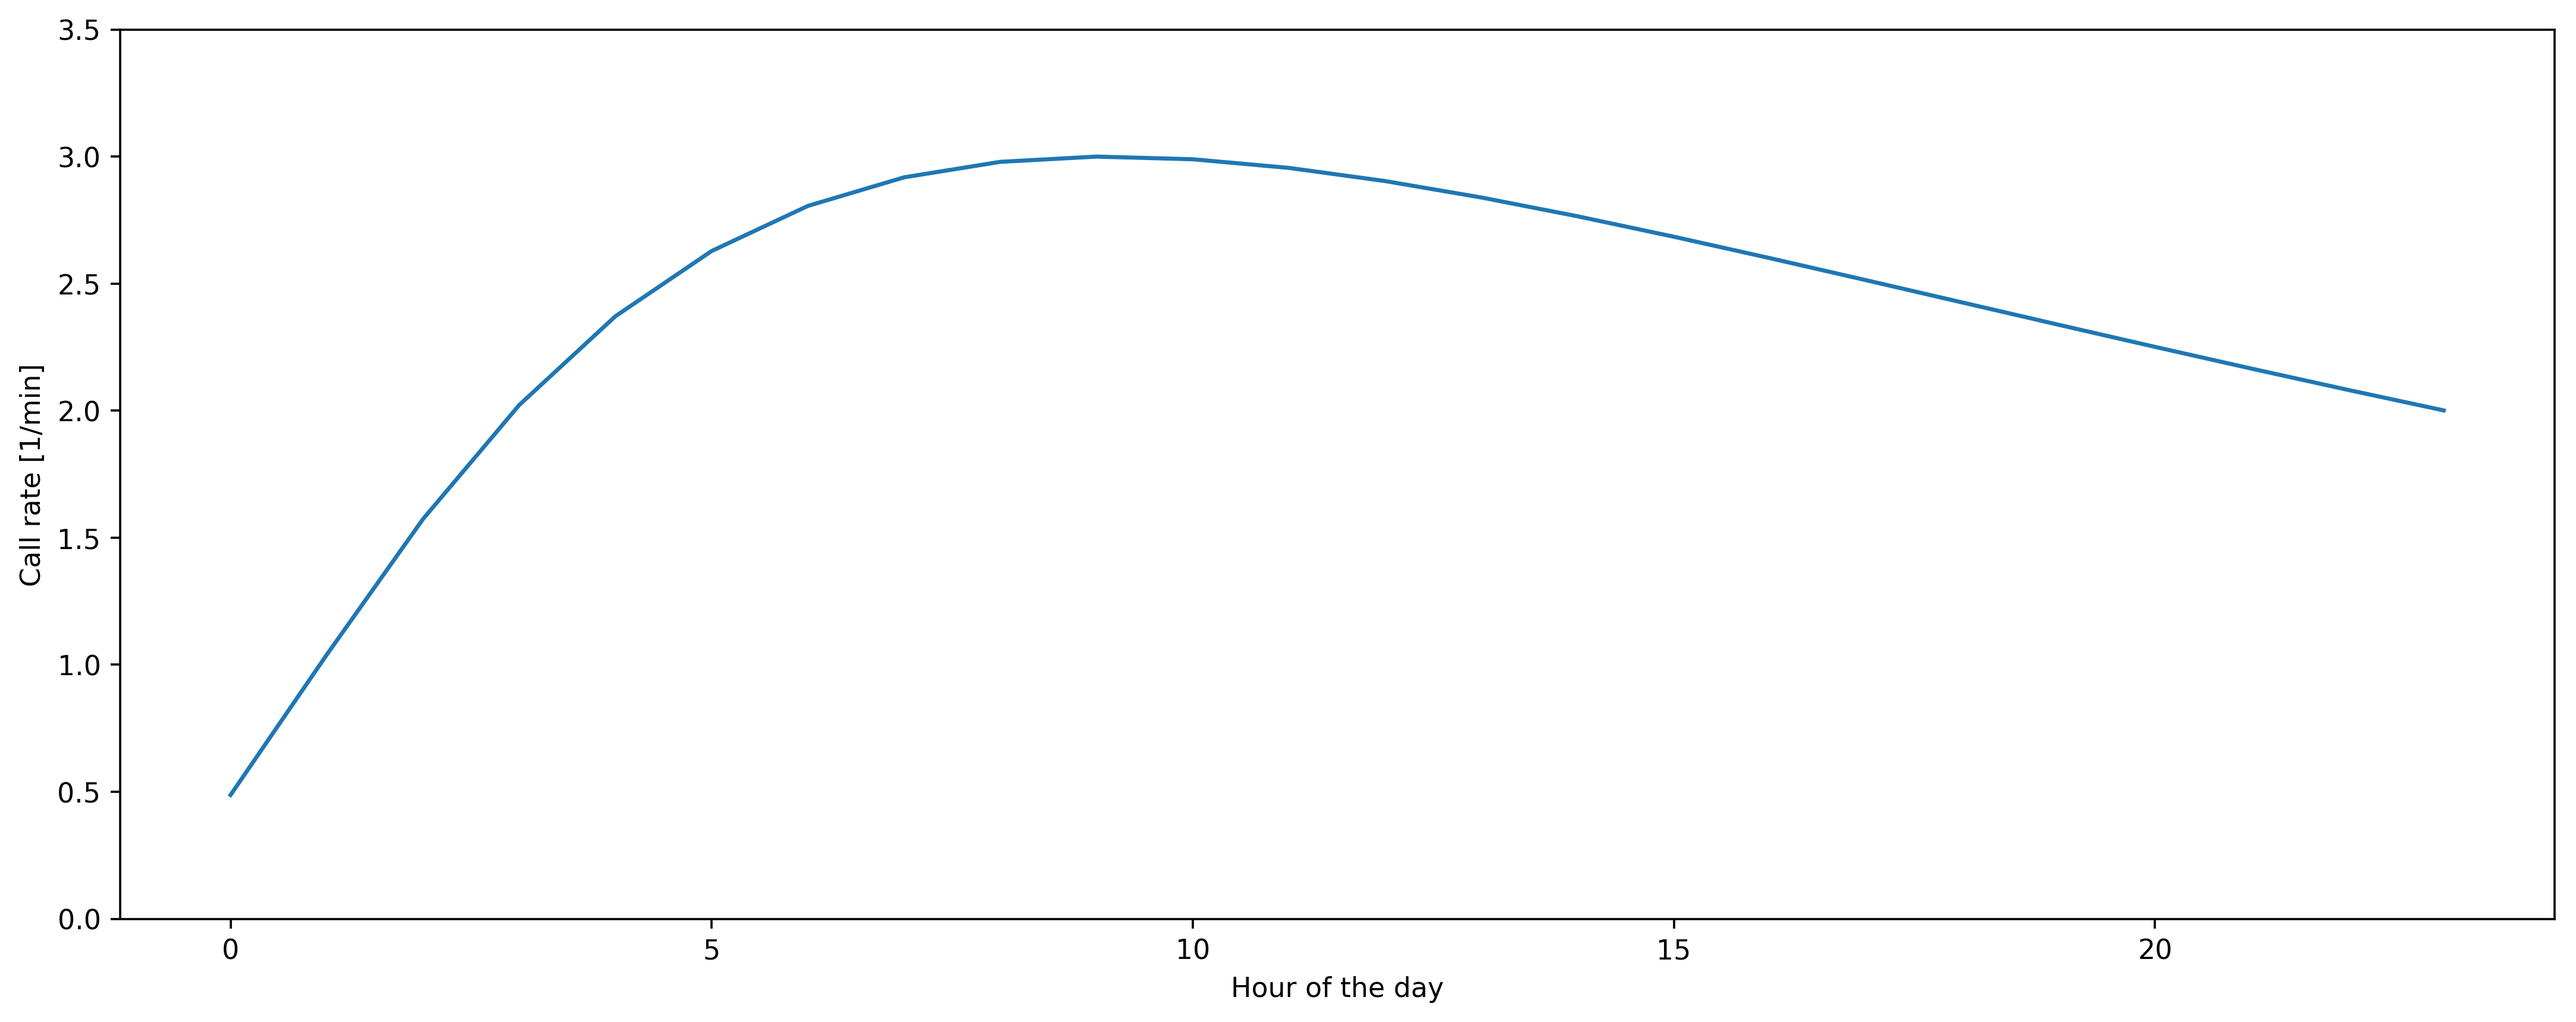

In [9]:
plt.figure(figsize=(16, 6), dpi=330)
plt.plot(range(24), call_rate)
plt.ylim((0, 3.5))
plt.xlabel('Hour of the day')
plt.ylabel('Call rate [1/min]')
plt.show()

Now that I got this distribution of call rates depending on the hour of the day, I will instantiate the gamma priors with mean = the call rate of that hour in the day. I will set scale, $\beta$, to be equal to $1$.

In [10]:
call_rate_pdf_storage = []
beta = 1

for hour in range(24):
    call_rate_pdf_storage.append(CallRatePDF(alpha=call_rate[hour], beta=beta))

Let's visualize all the priors:

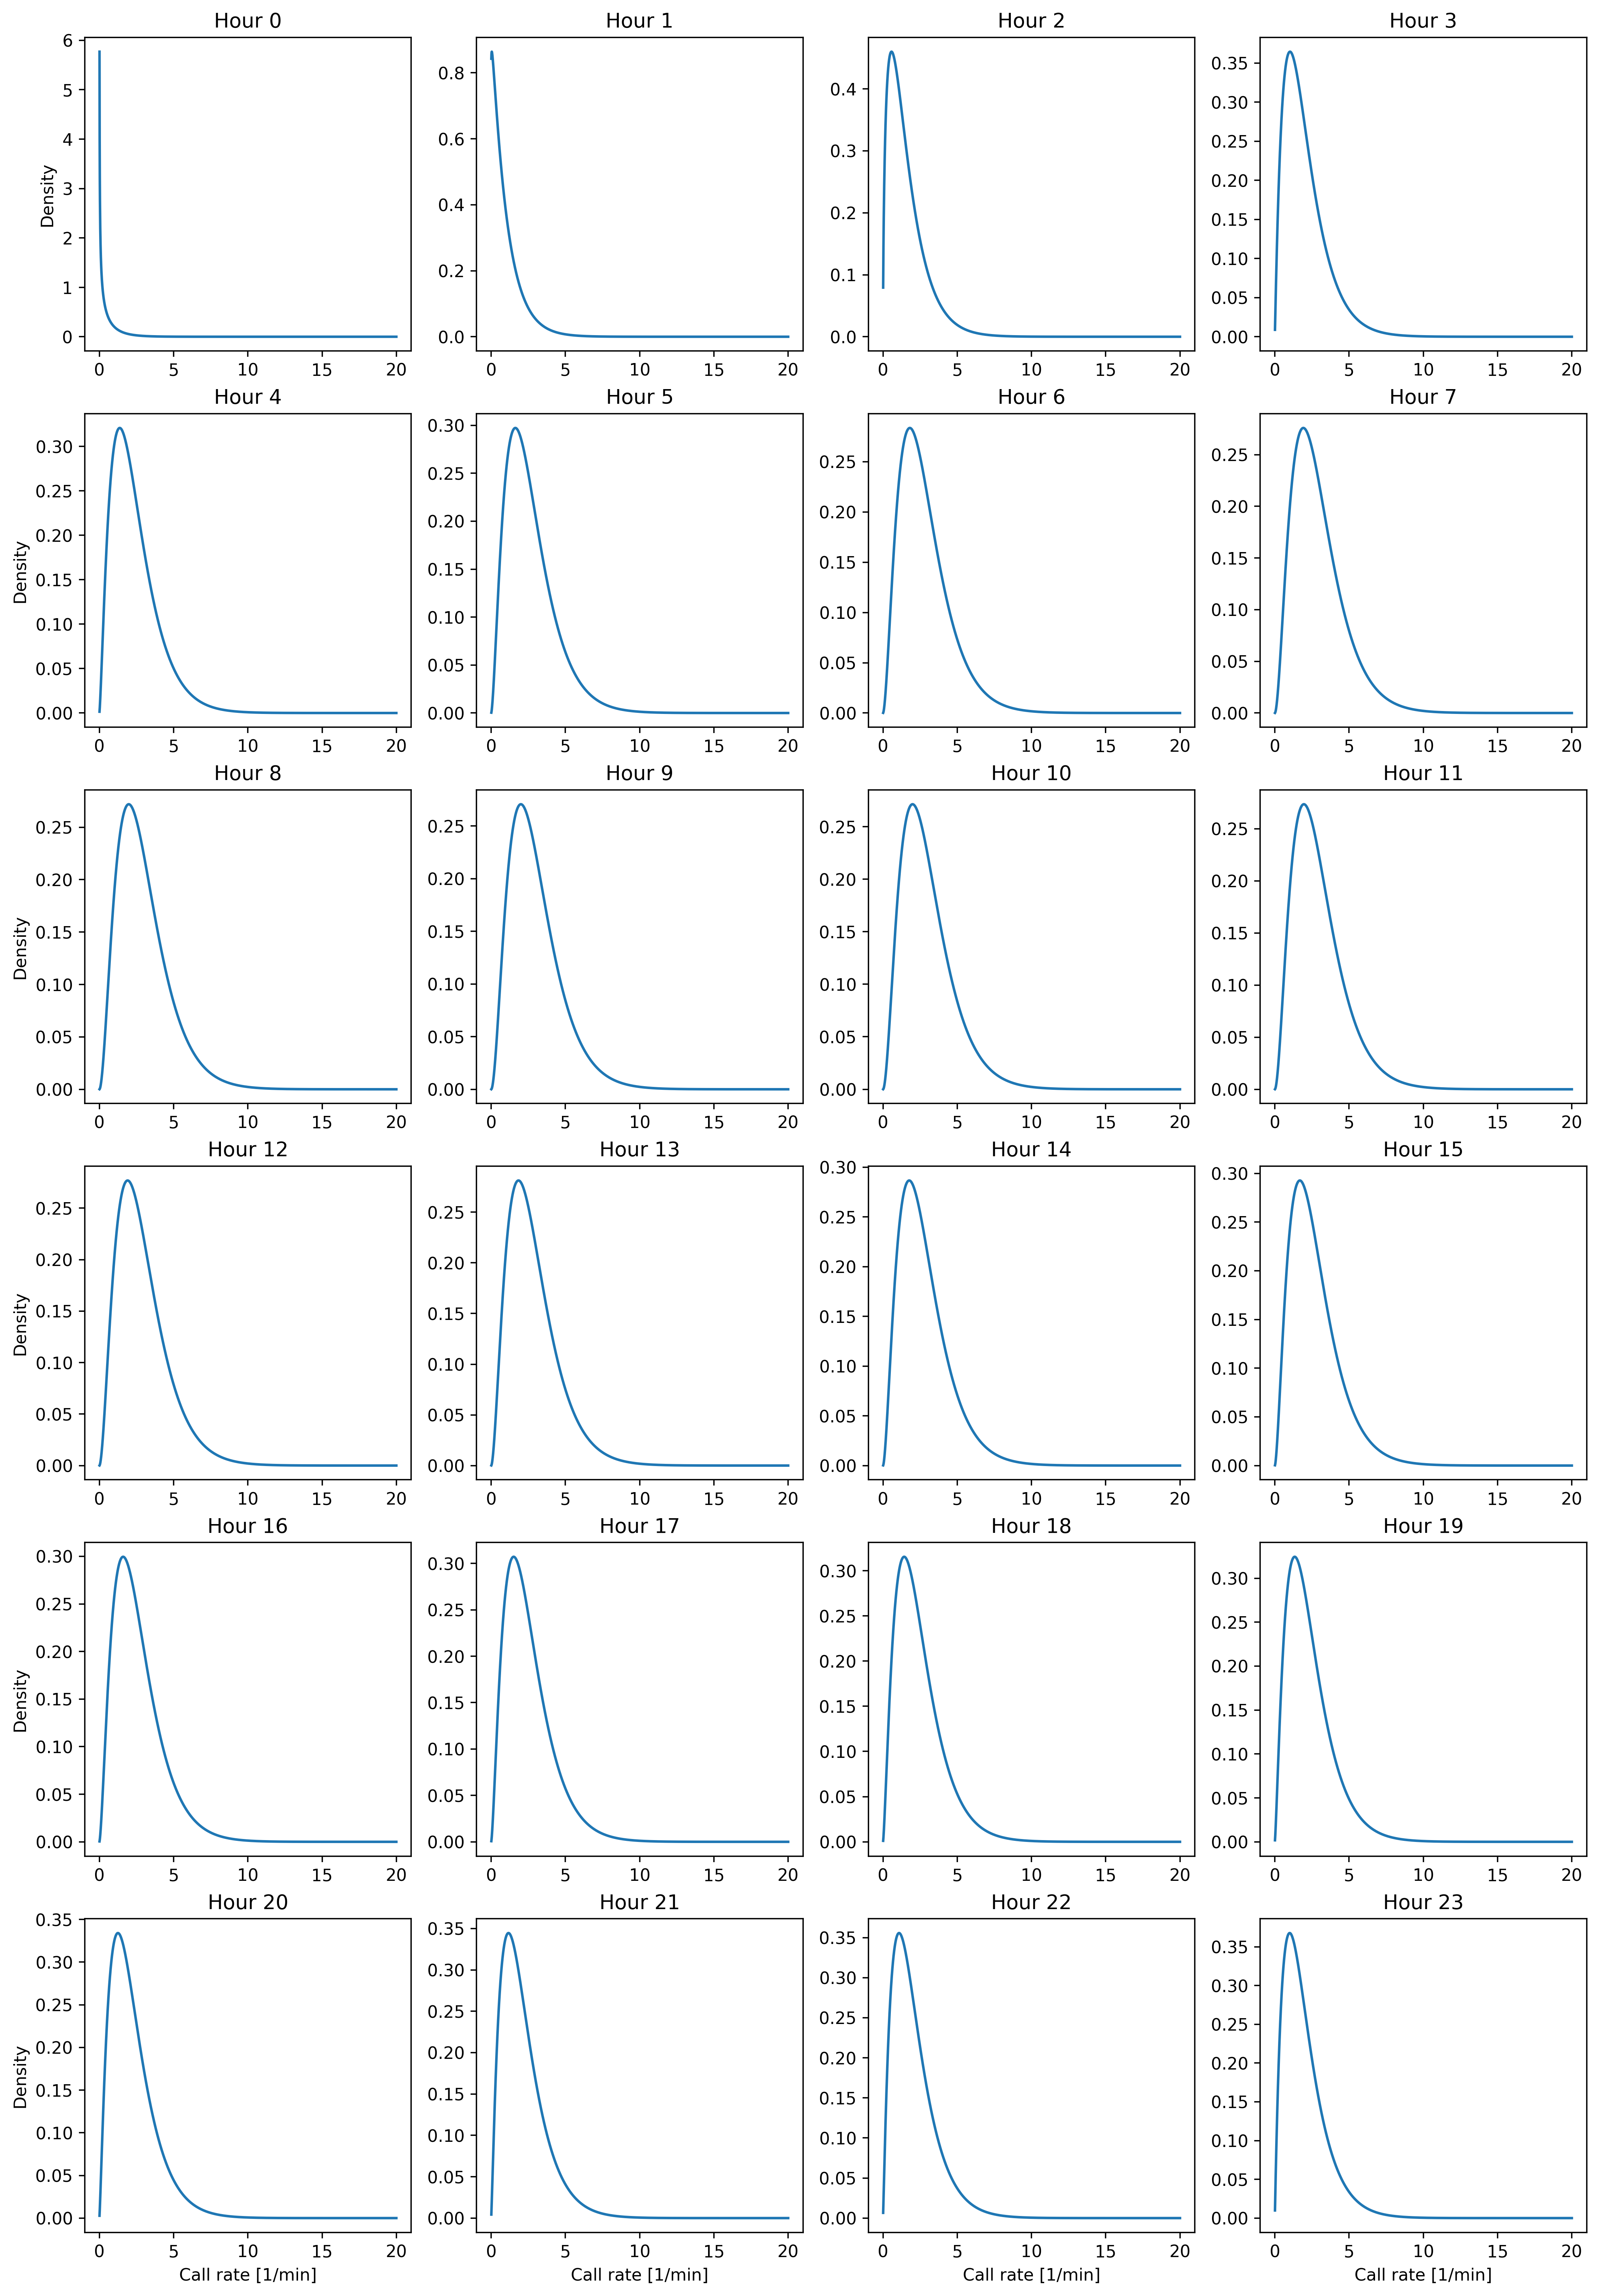

In [11]:
plt.figure(figsize=(16, 24), dpi=330)
lambdas = np.linspace(0, 20, 2000)[1:]
    
for hour in hours:
    call_rate_pdf = call_rate_pdf_storage[hour].prior_pdf(lambdas)
    plt.subplot(6, 4, hour + 1)
    plt.plot(lambdas, call_rate_pdf)
    plt.title('Hour {}'.format(hour))
    
    if hour >= 20:
        plt.xlabel('Call rate [1/min]')
    if hour % 4 == 0:
        plt.ylabel('Density')
    
plt.show()

### Get Posterior Distributions
Now we will go through each of the prior PDFs and inject data of that hour and get the posterior distributions of the call rate.

In [12]:
# run only once, otherwise data added twice
for hour in hours:
    call_rate_pdf_storage[hour].add_data(waiting_times_per_hour[hour])

Let's visualize all the posteriors on top of the priors:

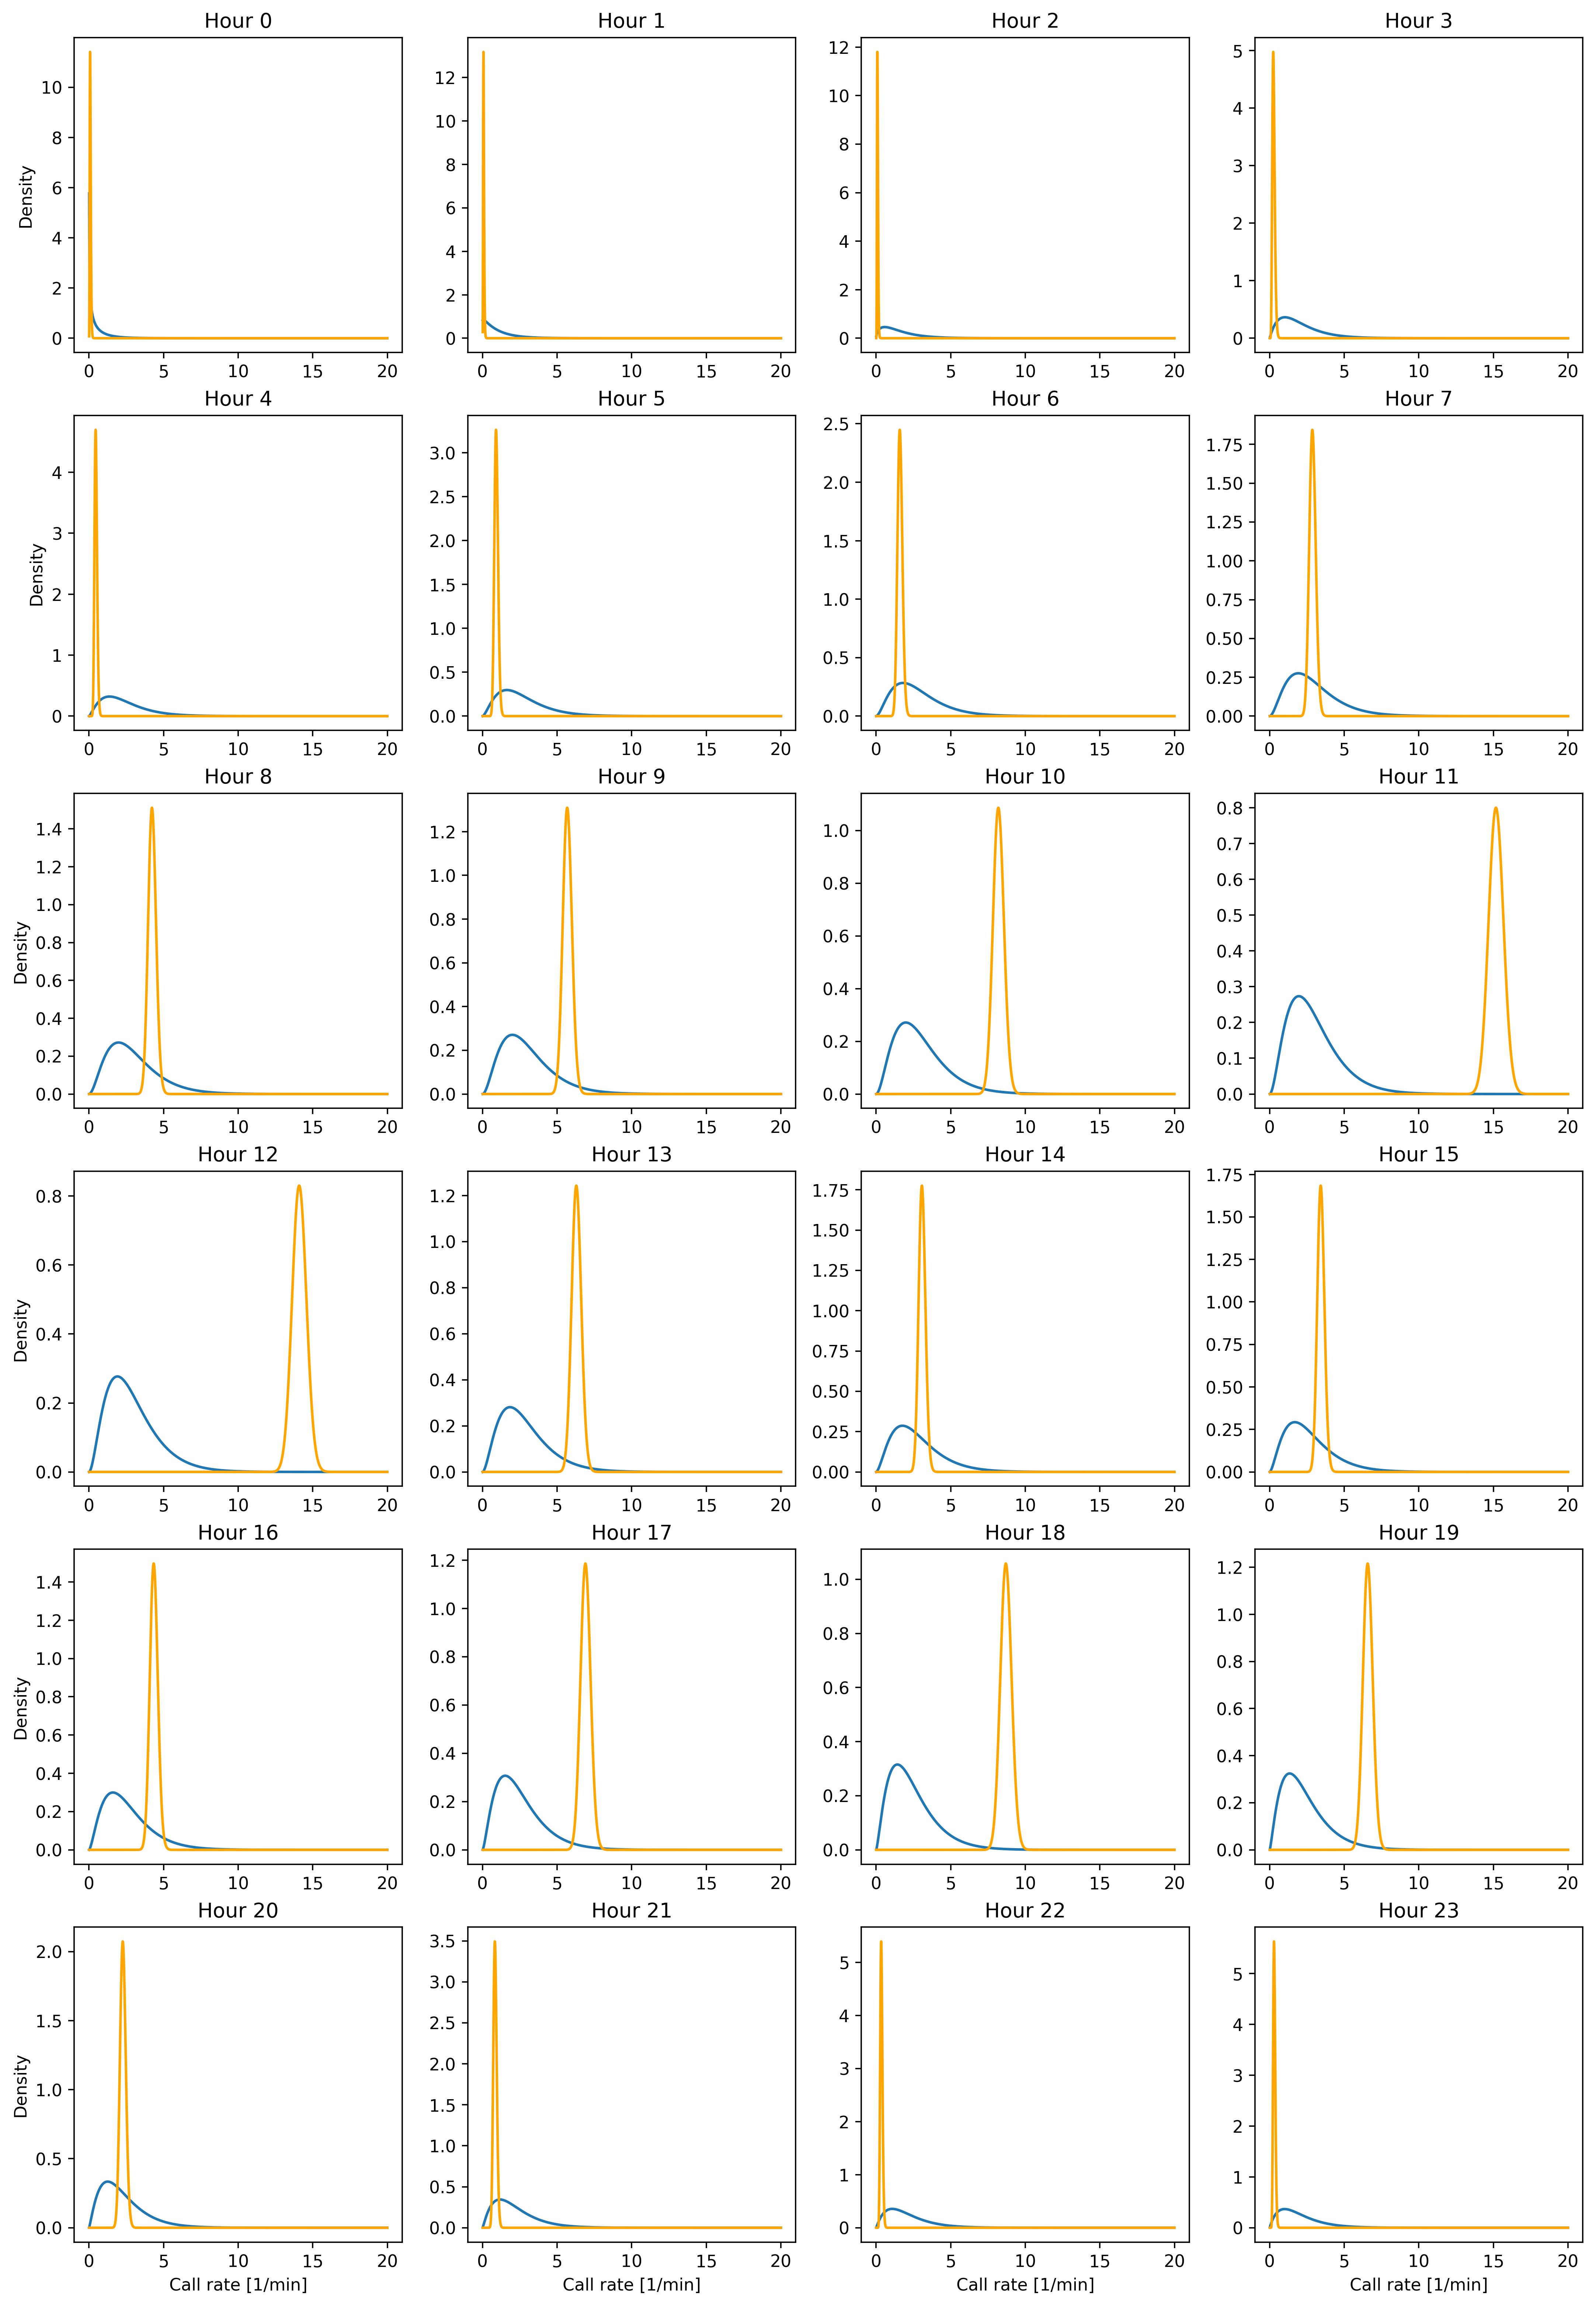

In [13]:
plt.figure(figsize=(16, 24), dpi=330)
for hour in hours:
    call_rate_pdf = call_rate_pdf_storage[hour].pdf(lambdas)
    prior_call_rate_pdf = call_rate_pdf_storage[hour].prior_pdf(lambdas)
    
    plt.subplot(6, 4, hour + 1)
    plt.plot(lambdas, prior_call_rate_pdf)
    plt.plot(lambdas, call_rate_pdf, color='orange')
    plt.title('Hour {}'.format(hour))
    
    if hour >= 20:
        plt.xlabel('Call rate [1/min]')
    if hour % 4 == 0:
        plt.ylabel('Density')
    
plt.show()

### 98% Confidence Interval and Means

In [14]:
def compute_percentile(parameter_values, distribution_values, percentile):
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    
    return lambdas[percentile_index]

conf_98_storage = []
mean_storage = []
for hour in hours:
    call_rate_pdf = call_rate_pdf_storage[hour].pdf(lambdas)
    percentiles = [compute_percentile(lambdas, call_rate_pdf, p) for p in [0.01, 0.99]]
    mean = compute_percentile(lambdas, call_rate_pdf, 0.5)
    
    conf_98_storage.append(percentiles)
    mean_storage.append(mean)

In [15]:
error_ranges = np.array(conf_98_storage).transpose() - mean_storage
error_ranges[0] = -error_ranges[0] # it's going down, but errorbar wants a positive down error

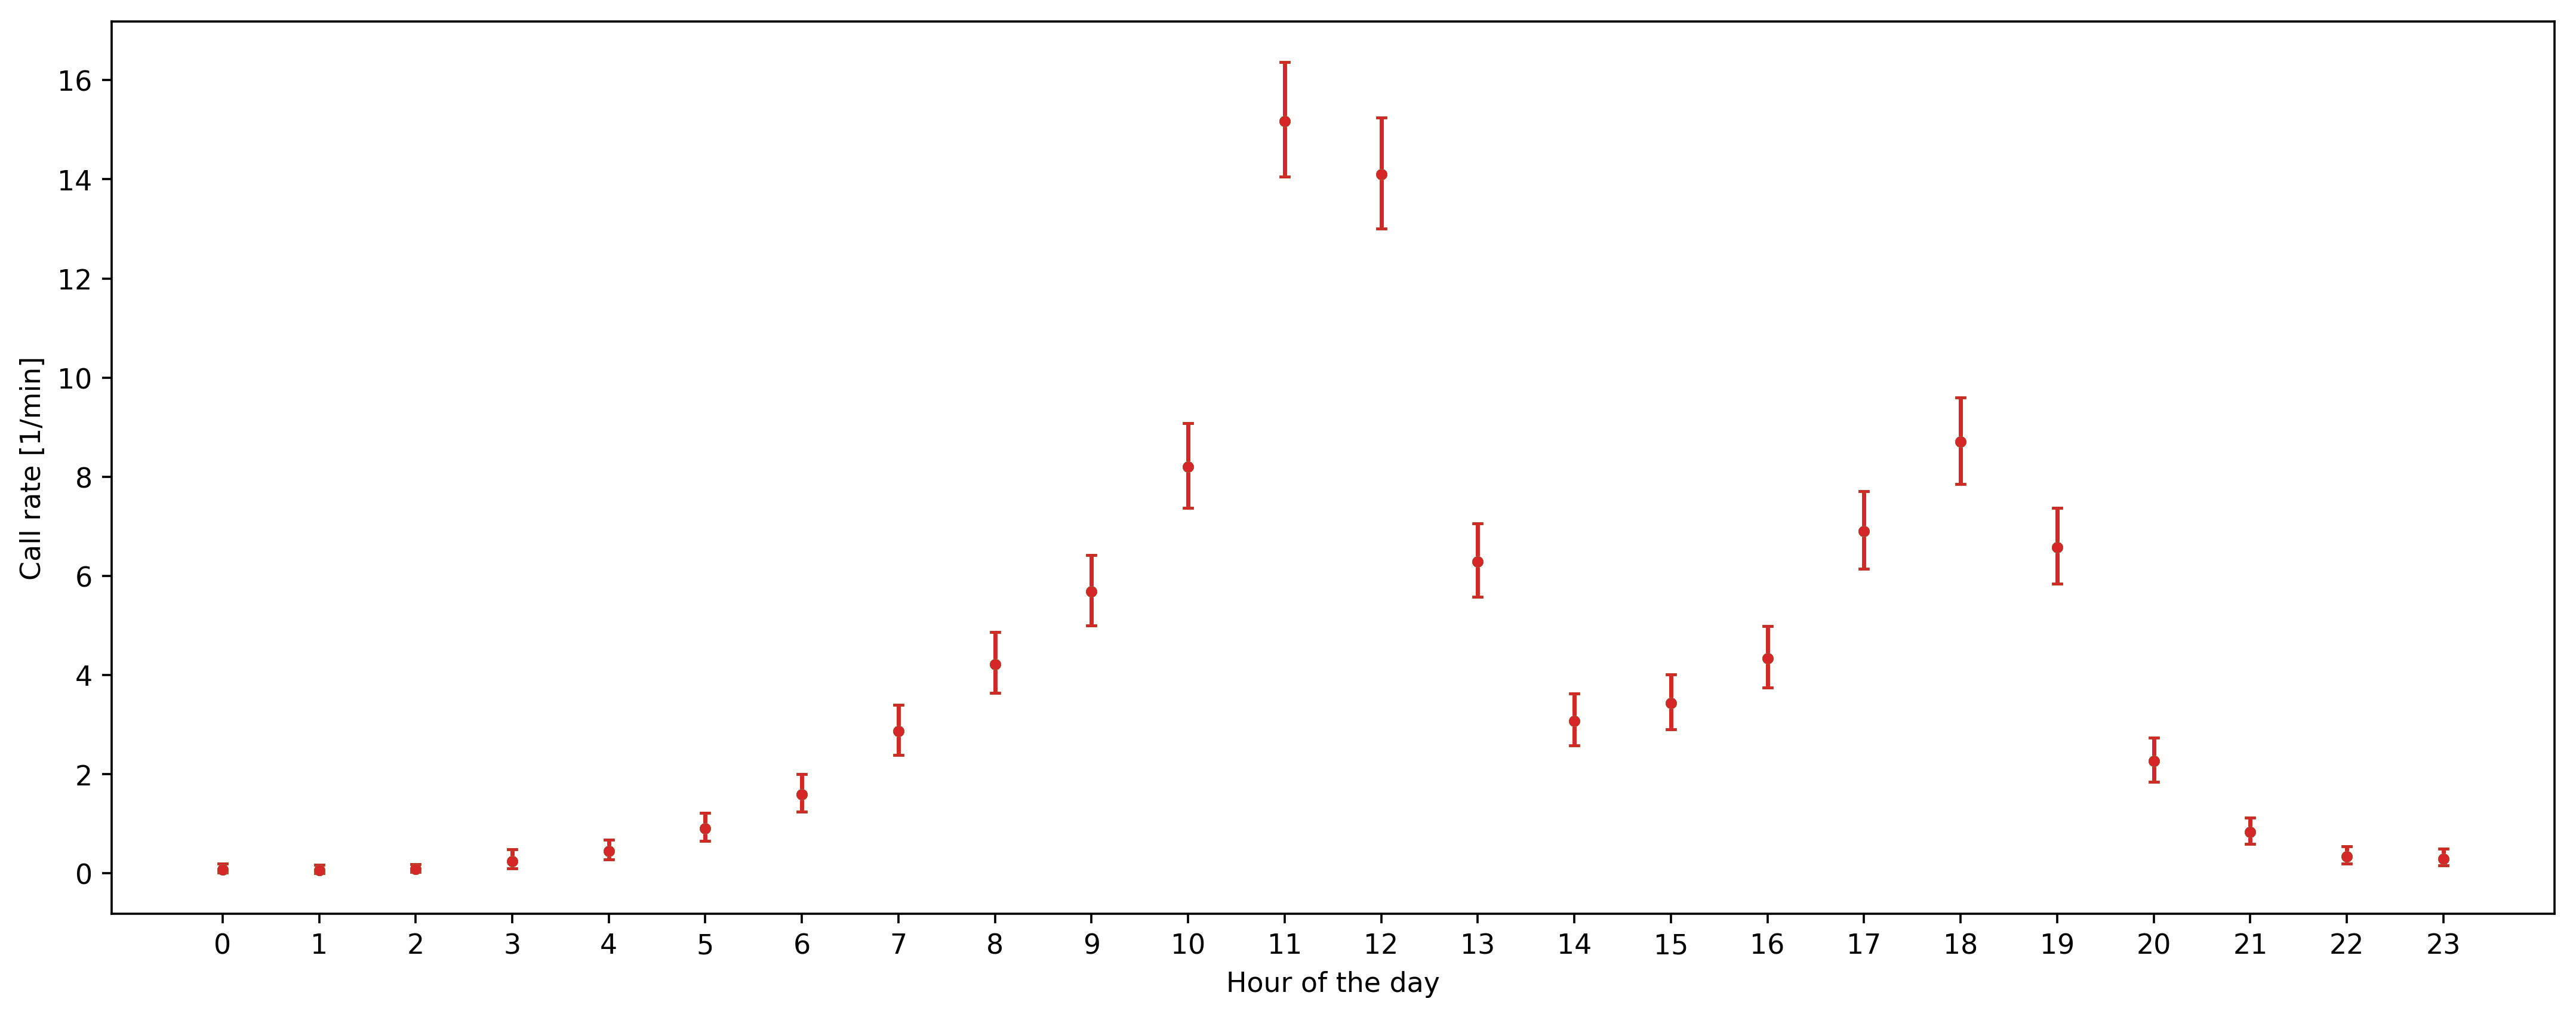

In [17]:
plt.figure(figsize=(16, 6), dpi=330)
for hour in hours:
    plt.errorbar(range(24), mean_storage, error_ranges, fmt='.', capsize=2)

plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Hour of the day')
plt.ylabel('Call rate [1/min]')
plt.show()

### Explanation of the Graph
We can see that the call rate peaks at hours 11 and 12. For hour 11, we are 98% confident that the call rate will be from 14.0 to 16.4 calls per minute. For hour 12, we are 98% confident that the call rate will be between 13.0 and 15.25. At lunch time (12-16), we can expect less than 8 calls per minute. If we take a look at the graph of our prior beliefs, the blue graph, we didn't expected so many calls at hours 9-19; therefore, the estimates have a lower confidence.

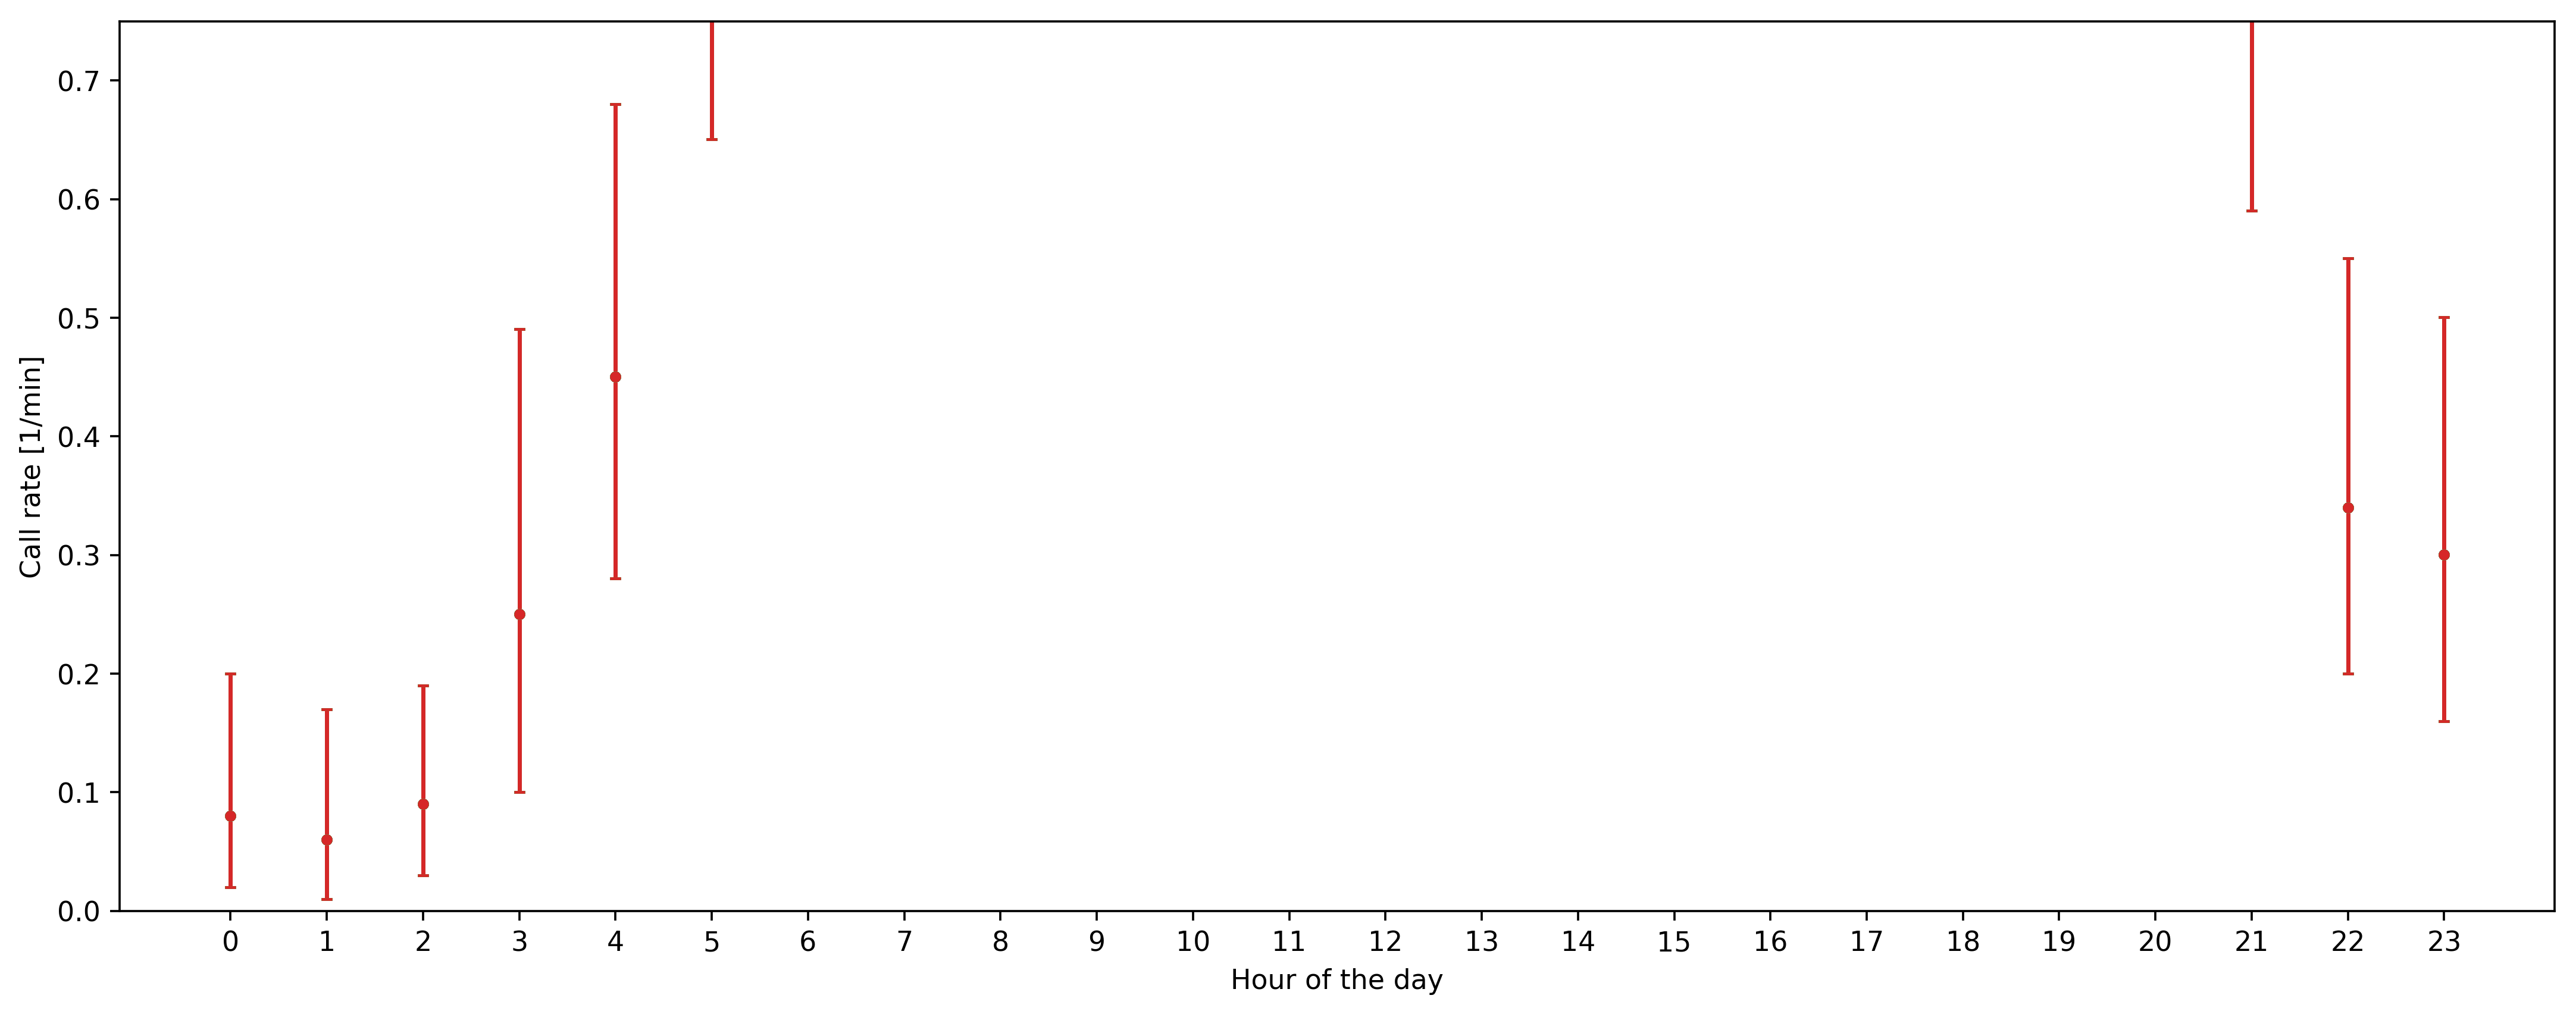

In [18]:
plt.figure(figsize=(16, 6), dpi=330)
for hour in hours:
    plt.errorbar(range(24), mean_storage, error_ranges, fmt='.', capsize=2)

plt.ylim((0, 0.75))
plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Hour of the day')
plt.ylabel('Call rate [1/min]')
plt.show()

Zooming in on hours 0 to 4 and 22 to 23, we can see that the call rate is lower than 1 call per minute. For hours 0, 1, 2 (when most people are sleeping), the call rate, and we are very certain that the rate will be below 0.3 calls per minute.